<div class="alert alert-block alert-warning">

# <p style="text-align: center;">Lab 3: Multi-Layer Perceptrons (MLP) </p>
<div style="text-align: center;">
<img src="data/thumbnail.png" width="544" height="300" />
</div>

Welcome to your third lab of ECE4179! Labs in this unit will run as a help desk and they are not mandatory to attend.

This notebook contains all the code and comments that you need to submit. Here are the instructions (same as Lab 1) to complete this lab:

- Your grade is entirely based on notebook completion (no quiz).
- After completing the notebook, submit it to Moodle under '**Lab 3 Submission**'.
- Before submission, make sure all outputs are visible by running all your cells from top to bottom (you can click _Run All_ at the top).
- IMPORTANT: Some parts of the notebook will be auto-graded, therefore please do not edit/rename the already-given variable/function/class names.

This lab has two tasks. These tasks will require you to use a deep learning library (Pytorch) for MLP-based problems. These knowledge and skills will be essential for Lab 4 and assignment, and in general, critical to get you prepared to enter the deep learning world.

- [Task 1: Shallow MLP to a sinusoidal function](#task1)
- [Task 2: Compare Shallow MLP and Deep MLP](#task2)

<div class="alert alert-block alert-warning">

### Pytorch

PyTorch is based on the Torch library, adapted for Python. PyTorch is a deep learning library that allows you to have greater control of your neural network architecture, and have a lot more customisable hyper parameters / functions (such as the loss function etc.). Learning PyTorch not only provides a strong foundation in deep learning but also makes it easier to transition to other popular libraries like TensorFlow and Keras.

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score

device = 'cpu' # this lab does not need gpu/cuda

def seed_all(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

<div class="alert alert-block alert-info">

## Task 1 - Approximate the sine function <a class="anchor" id="task1"></a>

In this section, we will approximate the sine function with a neural network to get a sense of how architecture and hyperparameters affect neural network performance.
<div style="text-align: center;">
<img src="data/sine.gif" width="500" />
</div>

### Learning Outcome
- Define the custom dataset class (i.e., Train and Test datasets) and visualize the train dataset you've created.
- Design the Shallow Linear MLP model using PyTorch.
- Train and evaluate the MLP model on defined train dataset and test dataset.
- Visualize experimental results using Matplotlib.

<div class="alert alert-block alert-info">

### 1.1 Create custom dataset and dataloaders <a class="anchor" id="1_1"></a>

Pytorch has a huge number of functionalities that make training our neural networks very easy! One of those functionalities is the Pytorch dataset and dataloader (they are real life-savers!). In depth review on PyTorch Datasets and Dataloaders are covered in Lectures!


In PyTorch, there are two Classes that can make the training process much easier - **Dataset** ([```torch.utils.data.Dataset```](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)) and **Dataloader** ([```torch.utils.data.DataLoader```](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)). Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples. Take a look that [this page](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) that explain further about data handling in PyTorch.

Simply speaking, a **Dataset** object loads the raw data and provides easy access to each sample (sample point + their label). Then a **Dataloader** object takes the Dataset object and creates batches of the data for model training/testing.

In the following section, let's create our Dataset and Dataloader.

#### (a) Creating a dataset

The dataset you are going to be creating will be points from a "noisy" sine wave. To create the custom dataset, you can use PyTorch dataset inbuilt functionalities. <br>


The Pytorch dataset class has three essential parts:<br>
1. The \__init__ function (as most Python classes do)<br>
2. The \__getitem__ function (this is called during every iteration)<br>
3. The \__len__ function (this must return the length of the dataset)

**Remember! The "self" within classes will become attributes of that class that you can use within other methods that are defined for that class. If you defined an attribute without self.<\name>, then that attribute cannot be used for other methods.**

Make sure to follow all inline comments specified for each code fragment that you need to work on.

In [24]:
# T1.1a IMPORTANT: Please do not edit/remove this comment.

# Prepare the Dataset class which stores our data and label.
# In real application, dataset is usually located in folders and need to be loaded into the class (we will do this in next task).
# In this task we will start simple, by artificially generating our data and label.
class SineDataset(Dataset):
    """ Data noisy sinewave dataset
        num_samples - the number of samples you want
        bound - the upper and lower bounds of the samples
    """
    def __init__(self, num_samples, bound):
        # This init function is where we load and store our dataset
        # In this task, our data is artificial (generated noisy sinewave points)
        
        # Create "num_samples" worth of random x points between -bound and +bound
        # by using torch.rand, then scale and shift
        self.x_data = (torch.rand(num_samples) * 2 * bound) - bound # Scale the tensor
        # print(self.x_data)
        
        # Calculate the sin of all data points in the x vector
        # and then scale amplitude to 0.5
        self.y_data = 0.5 * torch.sin(self.x_data)
        
        # Add some gaussian noise to each datapoint using torch.randn_like
        # The noise needs to be scaled down (use a factor of 0.08) before added to the signal,
        # otherwise it will be too noisy
        self.y_data += 0.08 * torch.randn_like(self.y_data)

    def __getitem__(self, idx):
        # This function returns the idx-th data of our already-loaded data (self.x_data and self.y_data)
        # This function will be called by DataLoader class whenever the latter wants a sample (x-y pair)
        # It is up to this function to prepare the (x-y pairs) for the DataLoader
        # If DataLoader wants a mini-batch, it will call this function repeatedly
        # DataLoader will also convert numpy array to tensor array, if not already in tensor
        
        # IMPORTANT: The indexed data (both x and y) should have 1-dimensional shape only,
        # i.e. its feature size. In this case, there is only 1 feature, so shape should be (1,) or torch.Size([1])
        x = self.x_data[idx].unsqueeze(0)
        y = self.y_data[idx].unsqueeze(0)
        sample = (x, y)
        return sample
    
    def __len__(self):
        # This function returns the total number of samples in our dataset
        # DataLoader will use this function to determine how many mini-batches to prepare.
        num_samples = len(self.x_data)
        return num_samples

#### (b) Create Dataset instance from the defined Class

Now that you've defined your dataset Class, lets create an instance of it for training and testing and then create dataloaders to make it easy to iterate.

In [25]:
# T1.1b IMPORTANT: Please do not edit/remove this comment.

num_train = 5000    # the number of training datapoints
num_test = 1000     # the number of testing datapoints
bound = 5           # we will create a sine wave between -5 and +5
bs_train = 32       # the batch size for training task 1
bs_test = 1         # the batch size for testing task 1

# Create an instance of the SineDataset for both the training and test set 
# For this task we will not use a validation set
dataset_train = SineDataset(num_train, bound)
dataset_test  = SineDataset(num_test, bound)

# Create dataloaders for both train and test by passing some arguments
# argument 1: the Dataset instance
# argument 2: batch size
# argument 3: shuffle (True for train, False for test)
loader_train = DataLoader(dataset_train, bs_train, shuffle=True)
loader_test = DataLoader(dataset_test, bs_test, shuffle=False)

#### (c) Visualise the dataset you've created!

Using scatter plot, visualize the train and test dataset in a 1 by 2 subplot. Access the data via the Dataset class instance that you have created.

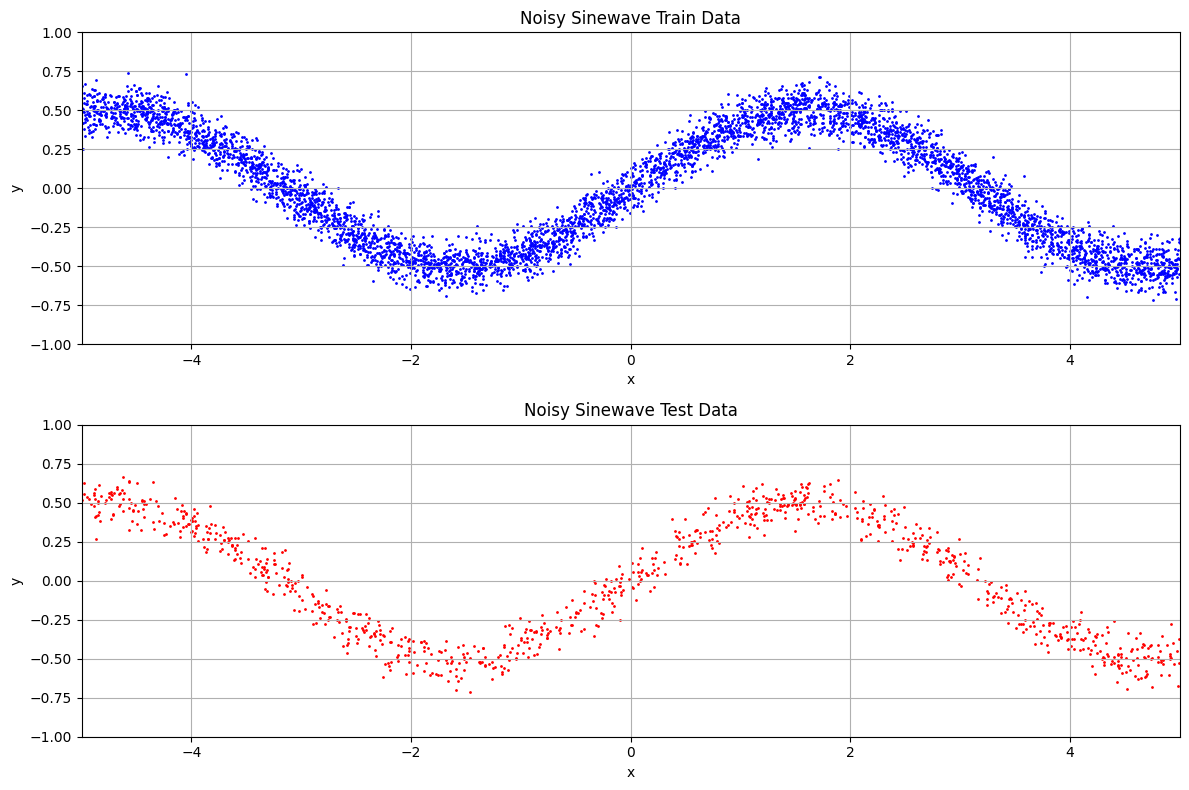

In [26]:
# T1.1c IMPORTANT: Please do not edit/remove this comment.

# Create the scatter plot using just the test data
# You can make the marker size smaller for better visibility

x_train = dataset_train.x_data.numpy()
y_train = dataset_train.y_data.numpy()
# print(np.size(x_train))
# print(np.size(y_train))
x_test = dataset_test.x_data.numpy()
y_test = dataset_test.y_data.numpy()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Create a scatter plot of the training data
axes[0].scatter(x_train, y_train, s=1, alpha=1, color='blue')
axes[0].set_xlim([-5,5])
axes[0].set_ylim([-1,1])
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
axes[0].set_title("Noisy Sinewave Train Data")
axes[0].grid()

axes[1].scatter(x_test, y_test, s=1, alpha=1, color='red')
axes[1].set_xlim([-5,5])
axes[1].set_ylim([-1,1])
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
axes[1].set_title("Noisy Sinewave Test Data")
axes[1].grid()

plt.tight_layout()
plt.show()




<div class="alert alert-block alert-info">

### 1.2 Design a Neural Network <a class="anchor" id="1_2"></a>

In this task, we will build a *Shallow MLP* that can be trained to approximate a sine wave.


#### Activation functions

You will start by creating a MLP—a neural network with one or many "hidden" layers separated by "**activation functions**" that give our network "**non-linearities**". If we don't have these activation functions and simply stacked layers together, our network would be no better than a single linear layer! (_Why?_)

In a MLP, only the output layer’s behavior is explicitly guided by the training data, as we compute a loss function based on its output and the corresponding label. In other words, the output layer produces values that are meaningful to us (i.e. the prediction). In contrast, the hidden layers do not have direct supervision—our training data do not specify what their outputs should be. As a result, the output values of hidden layers are implicitly learned by the algorithm, and do not have a clear, predefined physical meaning (hence the name "hidden"). This lack of interpretability makes trained neural networks resemble a "black box"—a complex system whose internal workings are hidden or not readily understood.

Each hidden unit receives inputs from multiple other units and computes its own activation value based on a chosen activation function. Our role is to select appropriate activation functions, while the learning process determines how the hidden layers contribute to achieving the final output. So what are these nonlinear activation functions that turn our simple linear models into a power "nonlinear function approximator"? Some common examples are:<br>
1. relu
2. sigmoid
3. tanh

Now, let's design a two layer Shallow MLP model with **one hidden layer** and **tanh** activation function using PyTorch. The model structure is given as follows:

fc1 : Linear(1 $\times$ d) $\rightarrow$ tanh $\rightarrow$ fc2 : Linear(d $\times$ 1)

Here since both the input data *x* and target value *y* are just one number, the input and output of the network are 1. And **d** is the dimension we define for the hidden layer.

We are going to use the **mean square error loss** for our model training - [```nn.MSELoss()```](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html).

There are two basic functions we first need to define: \_\_init__() and forward().

- In \_\_init__(), we define the structure/architecture of our model. Similar to all python classess, this function will be called when a new instance is made.

- In forward(), we define the forward propagation for the model. This method is called by the object to do forward pass.

Other core functions include:

- Train() - training procedures for our model.

- evaluate() - validation/testing procedures for our model that returns the loss.

- predict() - prediction procedures for our model that returns the ground truth and the prediction.

In [27]:
# T1.2 IMPORTANT: Please do not edit/remove this comment.

class ShallowMLP(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, device='cpu'):
        super().__init__()
        self.device = device

        # Define our layers
        self.fc1 = nn.Linear(input_size, hidden_size)  # Linear(1 × d)
        self.fc2 = nn.Linear(hidden_size, output_size)  # Linear(d × 1)

        self.to(device=device)

    def forward(self, x):
        # Define the forward pass of our model
        # print("Forward input shape:", x.shape)
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        return x
    
    def Train(self, epochs, optimizer, loader_train, loader_test, verbose=True):

        self.loss_train_log = []
        self.loss_test_log = []
        loss_fn = nn.MSELoss()

        for epoch in range(epochs):
            self.train() # need to specify as certain layers (e.g. dropout) behave differently in train/eval

            # in every epoch, we will:
            # (1) loop over loader_train to train the model
            # (2) calculate the loss of training data and save it (for loss curve)
            # (3) calculate the loss of val/testing data and save it (for loss curve)
            # (4) print training progress
            # don't need early stopping for this lab
            # Step (1)        
            for x, y in loader_train:

                x = x.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.float) # label is torch.float if regression, torch.long if classification

                # Reset the gradients
                optimizer.zero_grad()

                # Forward pass and calculate loss
                y_hat = self.forward(x)
                loss = loss_fn(y_hat, y)

                # Backward pass and update weights
                loss.backward()
                optimizer.step()

            # Step (2) (need to complete the self.evaluate function to work)
            loss_train = self.evaluate(loader_train)
            self.loss_train_log.append(loss_train)

            # Step (3) (need to complete the self.evaluate function to work)
            loss_test = self.evaluate(loader_test)
            self.loss_test_log.append(loss_test)

            # Step (4)
            if verbose:
                print('Epochs %d/%d' % (epoch+1, epochs))
                print('Train Loss = %.4f' % loss_train, end=', ')
                print('Test Loss = %.4f' % loss_test)


    def evaluate(self, loader):
        # this function is to evaluate the model on a given dataset (loader) by computing the average loss

        self.eval() # need to specify as certain layers (e.g. dropout) behave differently in train/eval
        loss_fn = nn.MSELoss(reduction='sum')
        loss = 0
        
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.float) # label is torch.float if regression, torch.long if classification

                # forward pass and calculate loss (test data) 
                yhat = self.forward(x)
                loss += loss_fn(yhat, y)
        
        loss /= len(loader.dataset)
        return loss.cpu()
    
    def predict(self, loader):
        # this function is to provide the model's prediction (and the corresponding ground truth) on a given dataset (loader).
        # both actual and pred should be arrays of shape (m,1) where m is the number of samples.

        self.eval() # need to specify as certain layers (e.g. dropout) behave differently in train/eval

        x_all, y_all, pred = [], [], []
        with torch.no_grad():
            
            for x, y in loader:
                x_all.append(x)
                y_all.append(y)
                
                x = x.to(device=self.device, dtype=torch.float)

                # forward pass and store predictions
                yhat = self.forward(x)
                pred.append(yhat.cpu())
            
            x_all, y_all, pred = torch.cat(x_all), torch.cat(y_all), torch.cat(pred)
            return x_all, y_all, pred

<div class="alert alert-block alert-info">

### 1.3 Train and evaluate the network  <a class="anchor" id="1_3"></a>

Now let's do some training for the network we just created! In this task, train our model using the following hyperparameters:
- Learning rate = 5e-3 (same as 0.005)
- Number of epochs = 10
- Hidden layer size = 16
- Optimizer = Adam

In [28]:
# T1.3 IMPORTANT: Please do not edit/remove this comment.

lr = 5e-3
epochs = 10
model = ShallowMLP(1, 16, 1)
optimizer = optim.Adam(model.parameters(), lr=lr)
# print("Before training:", model.fc1.weight.data)
model.Train(epochs, optimizer, loader_train, loader_test)
# print("After training:", model.fc1.weight.data)

Epochs 1/10
Train Loss = 0.0113, Test Loss = 0.0112
Epochs 2/10
Train Loss = 0.0083, Test Loss = 0.0079
Epochs 3/10
Train Loss = 0.0081, Test Loss = 0.0076
Epochs 4/10
Train Loss = 0.0079, Test Loss = 0.0074
Epochs 5/10
Train Loss = 0.0076, Test Loss = 0.0071
Epochs 6/10
Train Loss = 0.0075, Test Loss = 0.0072
Epochs 7/10
Train Loss = 0.0080, Test Loss = 0.0078
Epochs 8/10
Train Loss = 0.0085, Test Loss = 0.0079
Epochs 9/10
Train Loss = 0.0080, Test Loss = 0.0075
Epochs 10/10
Train Loss = 0.0071, Test Loss = 0.0067


<div class="alert alert-block alert-info">

### 1.4 Visualise and Analyse the Experimental Results <a class="anchor" id="1_4"></a>

Now the training is done. Let's check how well our model has performed.

There are a few ways we can evaluate the model performance:
- Evaluate accuracy
- Inspect the loss
- Precision, recall and F1-Score
- Confusion Matrix
And more

Let's try some of them here.

#### (a) Inspecting the loss

In the model class, there are two variables `self.loss_train_log` and `self.loss_test_log` which record the historical losses as the training progresses. Plot both the losses in the same figure to visualize the training progress, and ensure that proper labels and legend are in-place.

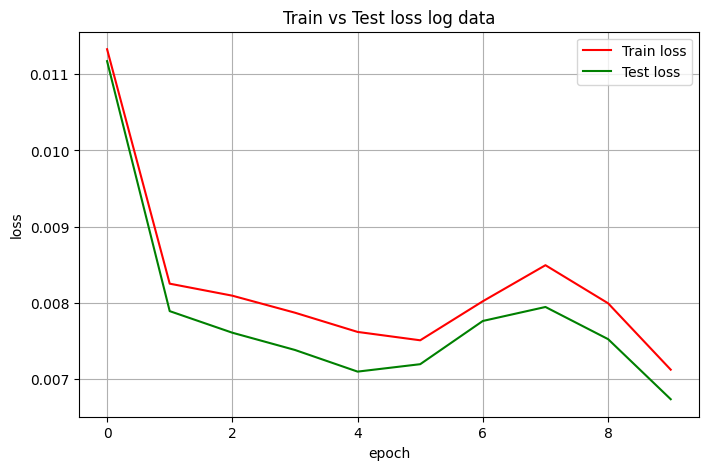

In [29]:
# T1.4a IMPORTANT: Please do not edit/remove this comment.

# Plot the losses in the same figure
plt.figure(figsize=(8, 5))


plt.plot(model.loss_train_log, color='red', label = 'Train loss')
plt.plot(model.loss_test_log, color='green', label = 'Test loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train vs Test loss log data")
plt.legend()
plt.grid(True)

#### (b) Visual check on the model predictions

Observe the performance of the trained model by visualising the ground truth and the prediction.
- Pass the test dataloader into the `predict` function of model class to obtain the ground truth and the prediction.
- Plot them in the same figure using scatter plot, with proper labels and legend.
- The plot should be similar to the Task 1 thumbnail:
<div style="text-align: center;">
<img src="data/sine.jpg" width="300" />
</div>

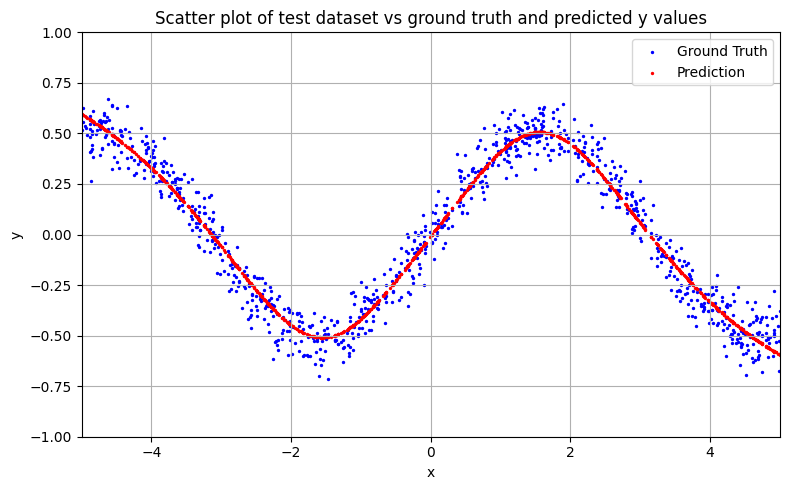

In [30]:
# T1.4b IMPORTANT: Please do not edit/remove this comment.

x_all, y_all, y_pred = model.predict(loader_test)

plt.figure(figsize=(8,5))

# Create a scatter plot of the training data
plt.scatter(x_all, y_all, s=2, alpha=1, color='blue', label = 'Ground Truth')
plt.scatter(x_all, y_pred, s=2, alpha=1, color='red', label = 'Prediction')
plt.xlim([-5,5])
plt.ylim([-1,1])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Scatter plot of test dataset vs ground truth and predicted y values")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">

## Task 2: Compare Shallow MLP and Deep MLP <a class="anchor" id="task2"></a>

<div style="text-align: center;">
<img src="data/mlp.png" width="800" />
</div>

In this task, you will be training a Shallow MLP and Deep MLP to predict the compressive strength of concrete. The details of the dataset are outlined as follows:

- The dataset consists of 8 input features which are used to predict the concrete compressive strength (output)
- There are a total of 1030 datapoints. In the `data` folder, you will find `concrete_train.csv` and `concrete_test.csv` containing 827 training data and 203 testing data respectively.
- The following table describes each column entry in the csv file:

| **Column Name**                | **Units**     | **Description**  |
|--------------------------------|---------------|------------------|
| Cement                         | kg/m^3   | Feature 1             |
| Blast Furnace Slag             | kg/m^3   | Feature 2             |
| Fly Ash                        | kg/m^3   | Feature 3             |
| Water                          | kg/m^3   | Feature 4             |
| Superplasticizer               | kg/m^3   | Feature 5             |
| Coarse Aggregate	             | kg/m^3   | Feature 6             |
| Fine Aggregate	             | kg/m^3   | Feature 7             |
| Age                            | day      | Feature 8             |
| Concrete compressive strength	 | MPa      | Target                |

### Learning Outcome
- Preprocess the Concrete Compressive Strength dataset and create the Dataset and DataLoader for it.
- Perform training of model using a shallow feedforward neural network
- Design a deep feedforward neural network using Pytorch and train the model
- Visualize and analyse the performance of both shallow and deep MLP in the dataset.

In [31]:
# The following code loads the data for this task and stores it as numpy array. Do not modify
data_train = pd.read_csv('data/concrete_train.csv').to_numpy()
data_test = pd.read_csv('data/concrete_test.csv').to_numpy()
print(f'Shape of train data: {data_train.shape}')
print(f'Shape of test data: {data_test.shape}')

print(data_train)

Shape of train data: (827, 9)
Shape of test data: (203, 9)
[[173.5   50.1  173.5  ... 793.5   14.    33.01]
 [262.   111.    86.   ... 733.    28.    33.72]
 [250.     0.    95.7  ... 861.2    3.    13.82]
 ...
 [144.     0.   175.   ... 844.    28.    15.42]
 [239.6  359.4    0.   ... 664.3   28.    39.44]
 [192.   288.     0.   ... 716.1   90.    50.73]]


<div class="alert alert-block alert-info">

### 2.1 Preprocessing of input features

Before we use the data for training, we need to preprocess the data first. If you open and check the csv files, you will see that the features and labels have different range of values. To train deep learning models, it is important to ensure that the values have similar scales for better convergence.

You are required to:
- Perform standardization (minus mean and divide by standard deviation)
- This needs to be done for every feature and the label (i.e. across the columns)
- In other words, for each column, we find the mean and std, then use these parameters to standardize each value in that column
- If done correctly, each column should have mean close to 0 and standard deviation close to 1 (You can use this fact to check)
- IMPORTANT: To standardize test data, you need to use the mean and std values from the TRAIN data !

In [32]:
# T2.1 IMPORTANT: Please do not edit/remove this comment.

# Find the parameters (mean and std) using np.mean and np.std function.
# Hint: Use the "axis" argument in the functions to find mean/std across columns
means = np.mean(data_train, axis=0)
devs = np.std(data_train, axis=0)
print(means)
print(devs)

# Standardize train data
data_train = (data_train-means) / devs

# Standardize test data
data_test = (data_test-means) / devs

[279.14594921  77.65610641  54.78355502 181.40024184   6.31995163
 971.70048368 773.25804111  45.68198307  36.0673156 ]
[104.46883183  88.13219128  64.50872213  21.37861547   5.95480162
  77.64559488  81.00390062  61.69871957  16.78874882]


<div class="alert alert-block alert-info">

### 2.2 Train a Shallow MLP

This task is similar to Task 1. We will:
- (a) create the custom Dataset
- (b) instantiate the class and create the dataloaders
- (c) reuse the ShallowMLP class defined in Task 1 to train a regression model for this task.

In [33]:
# T2.2a IMPORTANT: Please do not edit/remove this comment.

# You will follow the same process as you did in the first task: Dataset > DataLoader > Model
class ConcreteDataset(Dataset):
    def __init__(self, data):
        # We can directly pass the standardized data into the class here.
        data = torch.tensor(data, dtype=torch.float32) if isinstance(data, np.ndarray) else data

        # The task is simple here: to seperate the features (first 8 columns) and the label (last column)
        self.x_data = data[:,:8]
        self.y_data = data[:,8].unsqueeze(1)

    def __getitem__(self, idx):
        # This function returns the idx-th data of our already-loaded data (self.x_data and self.y_data)
        # This function will be called by DataLoader class whenever the latter wants a sample (x-y pair)
        # It is up to this function to prepare the (x-y pairs) for the DataLoader
        # If DataLoader wants a mini-batch, it will call this function repeatedly
        # IMPORTANT: The indexed data should have 1-dimensional shape only.
        x = self.x_data[idx] # make sure the shape is correct
        y = self.y_data[idx] # make sure the shape is correct
        sample = (x, y)
        return sample
    
    def __len__(self):
        # This function returns the total number of samples in our dataset
        # DataLoader will use this function to determine how many mini-batches to prepare.
        num_samples = len(self.x_data)
        return num_samples

In [34]:
# T2.2b IMPORTANT: Please do not edit/remove this comment.

bs_train = 32       # the batch size for training task 2
bs_test = 1         # the batch size for testing task 2

# Create an instance of the ConcreteDataset for both the training and test set 
dataset_train = ConcreteDataset(data_train)
dataset_test  = ConcreteDataset(data_test)

# Create dataloaders for both train and test
loader_train = DataLoader(dataset_train, bs_train, shuffle=True)
loader_test = DataLoader(dataset_test, bs_test, shuffle=False)

In [35]:
# T2.2c IMPORTANT: Please do not edit/remove this comment.

# Train the model here
# Use a learning rate of 1e-3, train for a total of 50 epochs, and set the hidden layer size to be 64
# Use the Adam optimizer
lr = 1e-3
epochs = 50
model_shallow = ShallowMLP(8, 64, 1)
optimizer = optim.Adam(model_shallow.parameters(), lr=lr)
model_shallow.Train(epochs, optimizer, loader_train, loader_test)

Epochs 1/50
Train Loss = 0.6769, Test Loss = 0.6547
Epochs 2/50
Train Loss = 0.4867, Test Loss = 0.4502
Epochs 3/50
Train Loss = 0.4072, Test Loss = 0.3636
Epochs 4/50
Train Loss = 0.3723, Test Loss = 0.3333
Epochs 5/50
Train Loss = 0.3514, Test Loss = 0.3198
Epochs 6/50
Train Loss = 0.3355, Test Loss = 0.3094
Epochs 7/50
Train Loss = 0.3224, Test Loss = 0.3000
Epochs 8/50
Train Loss = 0.3106, Test Loss = 0.2909
Epochs 9/50
Train Loss = 0.2999, Test Loss = 0.2832
Epochs 10/50
Train Loss = 0.2904, Test Loss = 0.2769
Epochs 11/50
Train Loss = 0.2809, Test Loss = 0.2676
Epochs 12/50
Train Loss = 0.2720, Test Loss = 0.2608
Epochs 13/50
Train Loss = 0.2638, Test Loss = 0.2554
Epochs 14/50
Train Loss = 0.2562, Test Loss = 0.2486
Epochs 15/50
Train Loss = 0.2491, Test Loss = 0.2404
Epochs 16/50
Train Loss = 0.2429, Test Loss = 0.2372
Epochs 17/50
Train Loss = 0.2378, Test Loss = 0.2321
Epochs 18/50
Train Loss = 0.2319, Test Loss = 0.2274
Epochs 19/50
Train Loss = 0.2272, Test Loss = 0.2243
Ep

<div class="alert alert-block alert-info">

### 2.3 Design and train a deep MLP

Here, we will create a new model class called DeepMLP. The difference between this class and our previous ShallowMLP class is only the structure/architecture of the model. Therefore, only the **init()** function and the **forward()** functions require modification.

You are required to create the model structure as follows:
- fc1 : Linear(input_size $\times$ hidden_size)
- fc2 : Linear(hidden_size $\times$ 64)
- fc3 : Linear(64 $\times$ 32)
- fc4 : Linear(32 $\times$ 16)
- fc5 : Linear(16 $\times$ output_size)

**Between** the linear layers, make sure to include the use of activation function. For this task, use the **ReLU** activation function.

In [36]:
# T2.3a IMPORTANT: Please do not edit/remove this comment.

class DeepMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device='cpu'):
        super().__init__()
        self.device = device

        # Define our layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, output_size)
        self.relu = nn.ReLU()
        
        self.to(device=device)

    def forward(self, x):

        # Define the forward pass of our model
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        
        return x
    
    def Train(self, epochs, optimizer, loader_train, loader_test, verbose=True):

        self.loss_train_log = []
        self.loss_test_log = []
        loss_fn = nn.MSELoss()

        for epoch in range(epochs):
            self.train() # need to specify as certain layers (e.g. dropout) behave differently in train/eval
            
            # in every epoch, we will do:
            # (1) loop over loader_train to train the model
            # (2) calculate the loss of training data and save it (for loss curve)
            # (3) calculate the loss of val/testing data and save it (for loss curve)
            # (4) print training progress
            # don't need early stopping for this lab

            # Step (1)        
            for x, y in loader_train:
                x = x.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.float) # label is torch.float if regression, torch.long if classification

                # Reset the gradients
                optimizer.zero_grad()

                # Forward pass and calculate loss
                y_hat = self.forward(x)
                loss = loss_fn(y_hat, y)

                # Backward pass and update weights
                loss.backward()
                optimizer.step()

            # Step (2) (need to complete the self.evaluate function to work)
            loss_train = self.evaluate(loader_train)
            self.loss_train_log.append(loss_train)

            # Step (3) (need to complete the self.evaluate function to work)
            loss_test = self.evaluate(loader_test)
            self.loss_test_log.append(loss_test)

            # Step (4)
            if verbose:
                print('Epochs %d/%d' % (epoch+1, epochs))
                print('Train Loss = %.4f' % loss_train, end=', ')
                print('Test Loss = %.4f' % loss_test)


    def evaluate(self, loader):
        self.eval() # need to specify as certain layers (e.g. dropout) behave differently in train/eval
        
        loss = 0
        loss_fn = nn.MSELoss(reduction='sum')

        with torch.no_grad():
            for x, y in loader:
                x = x.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.float) # label is torch.float if regression, torch.long if classification

                # forward pass and calculate loss
                yhat = self.forward(x)
                loss += loss_fn(yhat, y)

        loss /= len(loader.dataset)
        return loss.cpu()
    
    def predict(self, loader):
        self.eval() # need to specify as certain layers (e.g. dropout) behave differently in train/eval

        x_all, y_all, pred = [], [], []
        with torch.no_grad():
            for x, y in loader:
                x_all.append(x)
                y_all.append(y)
                
                x = x.to(device=self.device, dtype=torch.float)

                # forward pass and store predictions
                yhat = self.forward(x)
                pred.append(yhat.cpu())
            
            x_all, y_all, pred = torch.cat(x_all), torch.cat(y_all), torch.cat(pred)
            return x_all, y_all, pred

In [37]:
# T2.3b IMPORTANT: Please do not edit/remove this comment.

# Train the deep MLP model. Use the same hyperparameters as the previous one
# learning rate = 1e-3, epochs = 50, hidden size = 64, Adam optimizer
lr = 1e-3
epochs = 50
model_deep = DeepMLP(8, 64, 1)
optimizer = optim.Adam(model_deep.parameters(), lr=lr)
model_deep.Train(epochs, optimizer, loader_train, loader_test)

Epochs 1/50
Train Loss = 0.8436, Test Loss = 0.7752
Epochs 2/50
Train Loss = 0.4280, Test Loss = 0.3938
Epochs 3/50
Train Loss = 0.3436, Test Loss = 0.3267
Epochs 4/50
Train Loss = 0.2757, Test Loss = 0.2550
Epochs 5/50
Train Loss = 0.2312, Test Loss = 0.2180
Epochs 6/50
Train Loss = 0.1787, Test Loss = 0.1911
Epochs 7/50
Train Loss = 0.1585, Test Loss = 0.1744
Epochs 8/50
Train Loss = 0.1653, Test Loss = 0.1718
Epochs 9/50
Train Loss = 0.1397, Test Loss = 0.1577
Epochs 10/50
Train Loss = 0.1210, Test Loss = 0.1517
Epochs 11/50
Train Loss = 0.1095, Test Loss = 0.1417
Epochs 12/50
Train Loss = 0.1062, Test Loss = 0.1428
Epochs 13/50
Train Loss = 0.1048, Test Loss = 0.1293
Epochs 14/50
Train Loss = 0.1129, Test Loss = 0.1362
Epochs 15/50
Train Loss = 0.1185, Test Loss = 0.1546
Epochs 16/50
Train Loss = 0.0893, Test Loss = 0.1306
Epochs 17/50
Train Loss = 0.0862, Test Loss = 0.1323
Epochs 18/50
Train Loss = 0.0781, Test Loss = 0.1216
Epochs 19/50
Train Loss = 0.0835, Test Loss = 0.1302
Ep

<div class="alert alert-block alert-info">

### 2.4 Visualise and Analyse the Experimental Results

Let's check and compare the performance of our shallow and deep model. Similar to Task 1, we will inspect the loss as well as visualize the predictions using matplotlib.

#### (a) Inspecting the loss

For both model_shallow and model_deep, they have their respective train and test losses. Therefore, there are a total of 4 loss curves here. In order to compare the two models, plot all 4 loss curves **in the same figure**. Ensure that proper labels and legend are in-place.

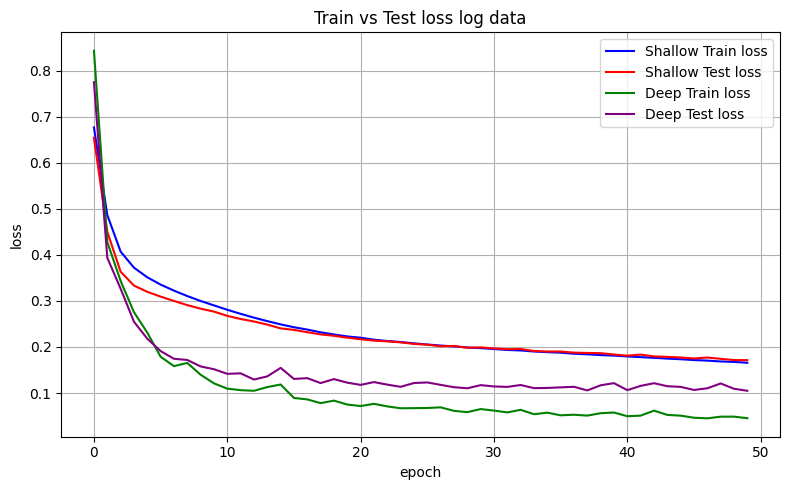

In [38]:
# T2.4a IMPORTANT: Please do not edit/remove this comment.

# T1.4a IMPORTANT: Please do not edit/remove this comment.

# Plot the losses in the same figure
plt.figure(figsize=(8, 5))

plt.plot(model_shallow.loss_train_log, color='blue', label = 'Shallow Train loss')
plt.plot(model_shallow.loss_test_log, color='red', label = 'Shallow Test loss')
plt.plot(model_deep.loss_train_log, color='green', label = 'Deep Train loss')
plt.plot(model_deep.loss_test_log, color='purple', label = 'Deep Test loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train vs Test loss log data")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

#### (b) Visual check on the model predictions

Observe the performance of the trained model by visualising the ground truth and the prediction.
- Pass the test dataloader into the `predict` function of model_shallow to obtain the ground truth and the prediction.
- For the plot, it will be slightly different from Task 1 - you are required to do a scatter plot, with the ground truth as the x-axis, and prediction as the y-axis.
- The plot should look something like this:
<div style="text-align: center;">
<img src="data/r2plot.jpg" width="200" />
</div>

- Plotting them this way is convenient to judge the performance. A perfect straight line indicates perfect prediction.
- Calculate the coefficient of determination (R2) for the model. The function `r2_score` has already been imported for you. Look up online to see how to use the function. (Note: the order of the argument is important!)
- Repeat this process with model_deep.
- Plot both scatter plot in the same figure, and include proper labels and legend.
- Make sure the calculated R2 values are visible in the plot as well.

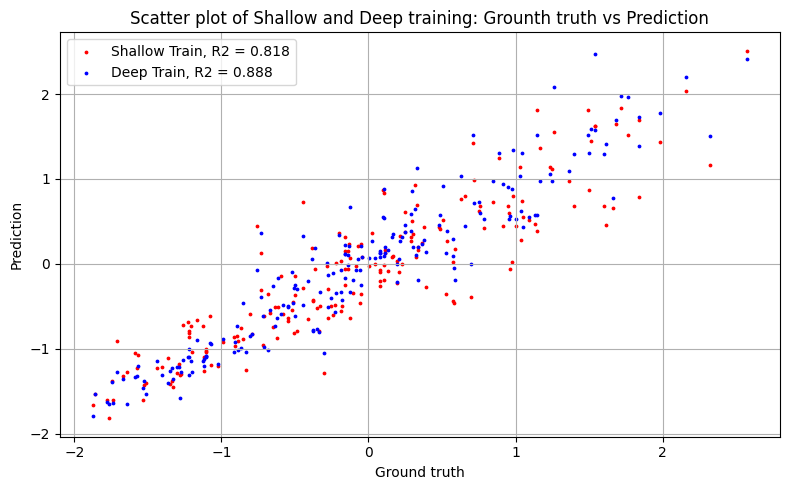

In [39]:
# T2.4b IMPORTANT: Please do not edit/remove this comment.

plt.figure(figsize=(8,5))

s_x_all, s_y_all, s_y_pred = model_shallow.predict(loader_test)
r2_shallow = r2_score(s_y_all, s_y_pred)
plt.scatter(s_y_all, s_y_pred, s=3, alpha=1, color='red', label = f'Shallow Train, R2 = {r2_shallow:.3f}')

d_x_all, d_y_all, d_y_pred  = model_deep.predict(loader_test)
r2_deep = r2_score(d_y_all, d_y_pred)
plt.scatter(d_y_all, d_y_pred, s=3, alpha=1, color='blue', label = f'Deep Train, R2 = {r2_deep:.3f}')

plt.xlabel("Ground truth")
plt.ylabel("Prediction")
plt.title("Scatter plot of Shallow and Deep training: Grounth truth vs Prediction")
plt.grid()
plt.legend()
plt.tight_layout()

plt.show()

In [40]:
model_deep.eval()
x, y = next(iter(loader_train))
x = x.to(torch.float32)
y = y.to(torch.float32)
with torch.no_grad():
    yhat = model_deep(x)
    loss = nn.MSELoss()(yhat, y)
    print("Manual loss:", loss.item())

Manual loss: 0.048285070806741714
